In [1]:
import os
import sys
import time

from IPython.display import Audio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
# Paths for data.
Tess = "/home/tai/snap/taimai/bluebelt/dataset/Tess/TESS Toronto emotional speech set data/"

In [3]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)

Tess_df.head()

,Emotions,Path
0,fear,/home/tai/snap/taimai/bluebelt/dataset/Tess/TE...
1,fear,/home/tai/snap/taimai/bluebelt/dataset/Tess/TE...
2,fear,/home/tai/snap/taimai/bluebelt/dataset/Tess/TE...
3,fear,/home/tai/snap/taimai/bluebelt/dataset/Tess/TE...
4,fear,/home/tai/snap/taimai/bluebelt/dataset/Tess/TE...


In [4]:
Tess_data = pd.concat([Tess_df], axis = 0)

# Shuffle the dataframe using the sample method
Tess_data = Tess_data.sample(frac=1).reset_index(drop=True) 

Tess_data.head()

,Emotions,Path
0,neutral,/home/tai/snap/taimai/bluebelt/dataset/Tess/TE...
1,neutral,/home/tai/snap/taimai/bluebelt/dataset/Tess/TE...
2,fear,/home/tai/snap/taimai/bluebelt/dataset/Tess/TE...
3,neutral,/home/tai/snap/taimai/bluebelt/dataset/Tess/TE...
4,fear,/home/tai/snap/taimai/bluebelt/dataset/Tess/TE...


In [5]:
Tess_data.Emotions.value_counts()

Emotions
neutral     400
fear        400
angry       400
disgust     400
surprise    400
happy       400
sad         400
Name: count, dtype: int64

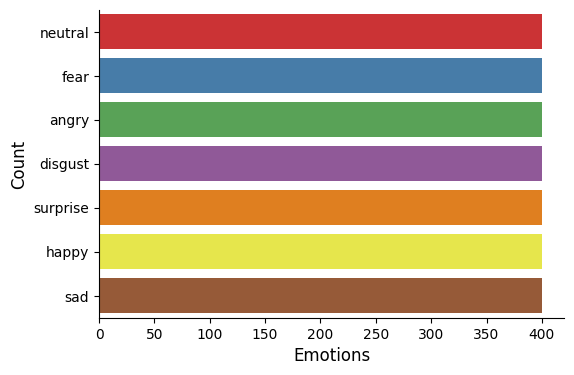

In [6]:
# Visualize the count of each emotion by chart bar, and put color on it.
plt.figure(figsize=(6,4))
sns.countplot(Tess_data.Emotions, palette="Set1")

plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [7]:
def create_waveplot(data, sr, e):
    """
    Create a waveplot for a given emotion.

    Parameters:
    data (numpy.ndarray): The audio data.
    sr (int): The sample rate of the audio.
    e (str): The emotion.

    Returns:
    None
    """
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()


def create_spectrogram(data, sr, e):
    """
    Create a spectrogram for the given audio data.

    Parameters:
    - data: numpy.ndarray
        The audio data.
    - sr: int
        The sample rate of the audio data.
    - e: str
        The emotion associated with the audio data.

    Returns:
    None
    """
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

In [8]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=int(pitch_factor * 6))

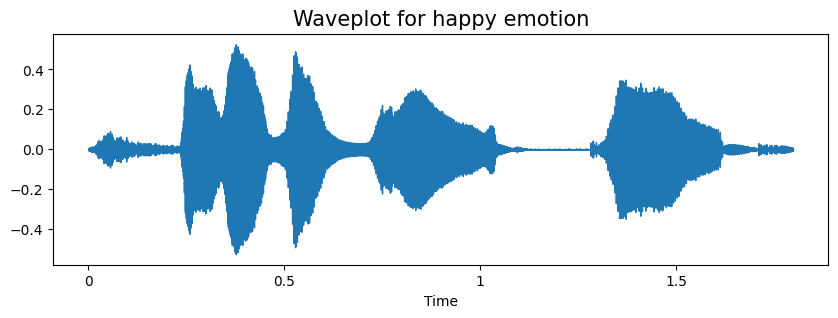

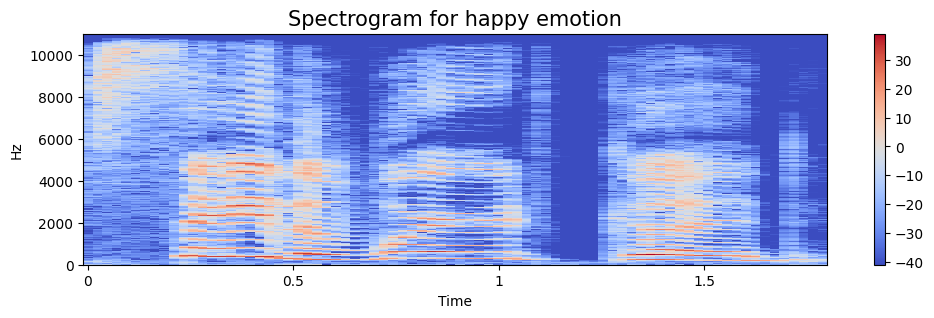

In [9]:
emotion='happy'
path = np.array(Tess_data.Path[Tess_data.Emotions==emotion])[2]
data, sample_rate  = librosa.load(path)

create_waveplot(data, sample_rate, emotion)
create_spectrogram(data, sample_rate, emotion)
Audio(path)

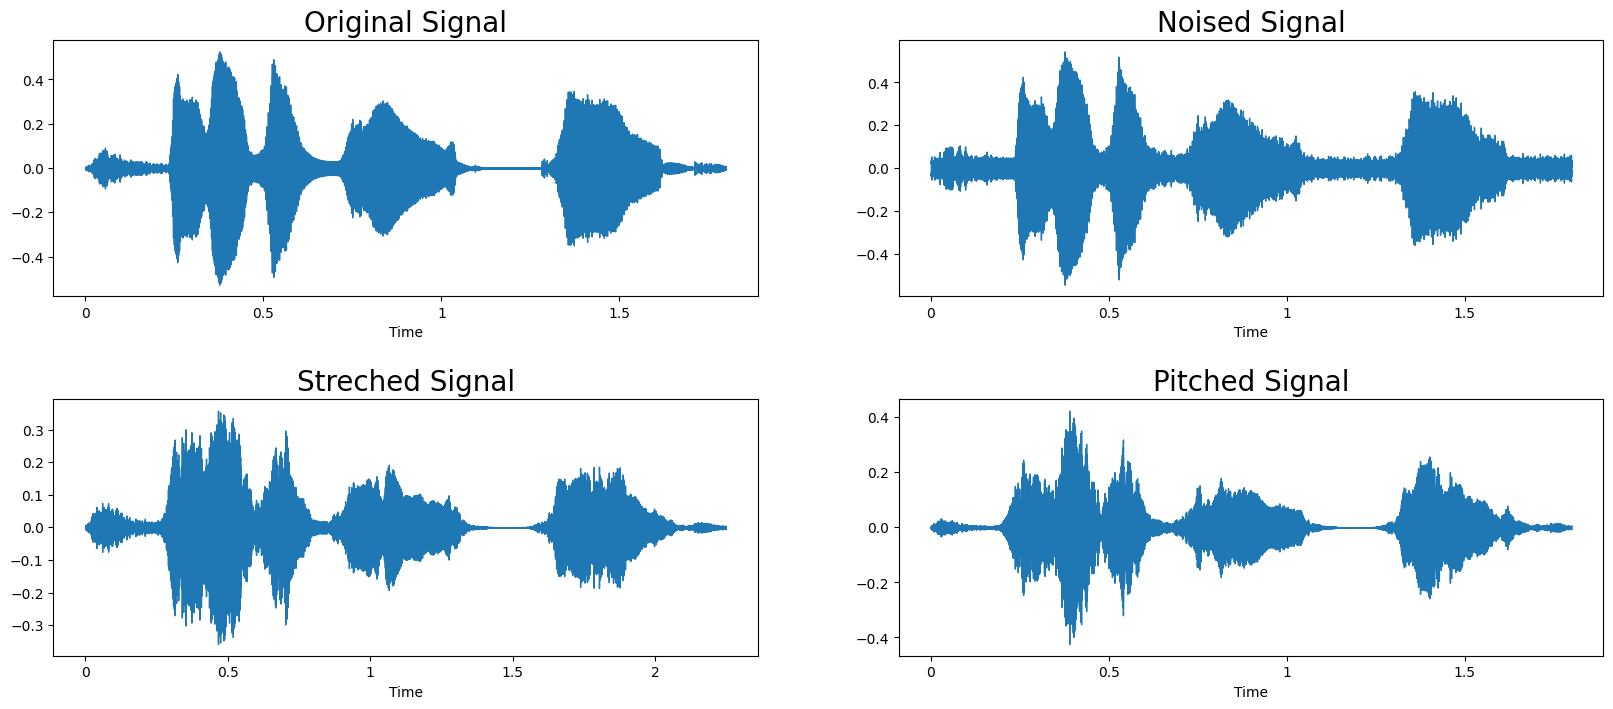

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(20,8))
plt.subplots_adjust(hspace=0.4)

axs[0, 0].set_title('Original Signal', size=20)
librosa.display.waveshow(y=data, sr=sample_rate, ax=axs[0, 0])


axs[0, 1].set_title('Noised Signal', size=20)
noise_data = noise(data)
librosa.display.waveshow(y=noise_data, sr=sample_rate, ax=axs[0, 1])

axs[1, 0].set_title('Streched Signal', size=20)
stretch_data = stretch(data)
librosa.display.waveshow(y=stretch_data, sr=sample_rate, ax=axs[1, 0])

axs[1, 1].set_title('Pitched Signal', size=20)
pitch_data = pitch(data, sample_rate)
librosa.display.waveshow(y=pitch_data, sr=sample_rate, ax=axs[1, 1])

plt.show()

In [11]:
labels = {'neutral':0, 'happy':1, 'disgust':2, 'angry':3, 'sad':4, 'fear':5, 'surprise':6}
# labels = {'neutral':0, 'happy':1, 'unpleasant':2, 'surprise':3}
Tess_data.replace({'Emotions':labels},inplace=True)
Tess_data.head()

,Emotions,Path
0,0,/home/tai/snap/taimai/bluebelt/dataset/Tess/TE...
1,0,/home/tai/snap/taimai/bluebelt/dataset/Tess/TE...
2,5,/home/tai/snap/taimai/bluebelt/dataset/Tess/TE...
3,0,/home/tai/snap/taimai/bluebelt/dataset/Tess/TE...
4,5,/home/tai/snap/taimai/bluebelt/dataset/Tess/TE...


In [12]:
NUM_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 512
SAMPLE_RATE = 22050
DOWN_SAMPLE_RATE = 16000
SAMPLE_NUM = Tess_data.shape[0]

data = {
        "labels": [],
        "features": []
    }

def extract_features(data, sample_rate):
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=NUM_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
    feature = mfcc.T
    return feature

for i in range(SAMPLE_NUM):
    for j in range(2):
        data['labels'].append(Tess_data.iloc[i,0])
    signal, sample_rate = librosa.load(Tess_data.iloc[i,1], sr=SAMPLE_RATE)
    
    # Cropping & Resampling
    start_time = 0.4  # Start time in seconds
    end_time = 1.9  # End time in seconds
    start_frame = int(start_time * sample_rate)
    end_frame = int(end_time * sample_rate)
    signal = signal[start_frame:end_frame]
    signal = librosa.resample(signal, orig_sr=sample_rate, target_sr=DOWN_SAMPLE_RATE)
    
    # Add noise
    signal = noise(signal)
    res1 = extract_features(signal, DOWN_SAMPLE_RATE)
    data["features"].append(np.array(res1))
    
    # Stretch and shift pitch
    new_data = stretch(signal)[:24000]
    data_stretch_pitch = pitch(new_data, DOWN_SAMPLE_RATE)
    res2 = extract_features(data_stretch_pitch, DOWN_SAMPLE_RATE)
    data["features"].append(np.array(res2))
    
    if i % 100 == 0:
        print(f'Processing Data: {i}/{SAMPLE_NUM}')

Processing Data: 0/2800
Processing Data: 100/2800
Processing Data: 200/2800
Processing Data: 300/2800
Processing Data: 400/2800
Processing Data: 500/2800
Processing Data: 600/2800
Processing Data: 700/2800
Processing Data: 800/2800
Processing Data: 900/2800
Processing Data: 1000/2800
Processing Data: 1100/2800
Processing Data: 1200/2800
Processing Data: 1300/2800
Processing Data: 1400/2800
Processing Data: 1500/2800
Processing Data: 1600/2800
Processing Data: 1700/2800
Processing Data: 1800/2800
Processing Data: 1900/2800
Processing Data: 2000/2800
Processing Data: 2100/2800
Processing Data: 2200/2800
Processing Data: 2300/2800
Processing Data: 2400/2800
Processing Data: 2500/2800
Processing Data: 2600/2800
Processing Data: 2700/2800


In [13]:
Features_Tess = pd.DataFrame()
Features_Tess['features'] = data["features"]
Features_Tess['labels'] = data["labels"]
Features_Tess.head()

,features,labels
0,"[[-243.57294952396197, 66.71679687500327, 14.7...",0
1,"[[-238.53219060076987, 54.02796539115204, 30.7...",0
2,"[[-208.29394353049446, 71.76629169256452, 6.22...",0
3,"[[-207.10014861475642, 62.202471422535965, 7.1...",0
4,"[[-308.9638554049631, 88.80364751389655, 21.95...",5


In [14]:
X = np.asarray(Features_Tess['features'])
y = np.asarray(Features_Tess["labels"])

# Pad Features to make them of equal length
X = tf.keras.preprocessing.sequence.pad_sequences(X)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

print(f'Training Data:{X_train.shape} with label {y_train.shape}')
print(f'Validate Data:{X_validation.shape} with label {y_validation.shape}')
print(f'Testing Data:{X_test.shape} with label {y_test.shape}')

num_classes = len(np.unique(y_train))
print('Number of class:"',num_classes)

Training Data:(4032, 47, 13) with label (4032,)
Validate Data:(1008, 47, 13) with label (1008,)
Testing Data:(560, 47, 13) with label (560,)
Number of class:" 7


In [16]:
def build_model(input_shape):
    model = Sequential()

    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.3))

    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.3))

    model.add(LSTM(32))
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(num_classes, activation='softmax'))
    return model

# Create network
input_shape = (47,13)
model = build_model(input_shape)

# Compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

2023-12-28 02:53:05.768114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-28 02:53:05.771739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-28 02:53:05.771817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-28 02:53:05.771989: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 47, 128)           72704     
                                                                 
 dropout (Dropout)           (None, 47, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 47, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 47, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2

In [17]:
# Run the training process
EPOCHS = 50
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=128, epochs=EPOCHS)

Epoch 1/50


2023-12-28 02:53:34.682309: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201


12/32 [==========>...................] - ETA: 0s - loss: 1.9473 - accuracy: 0.1673 

2023-12-28 02:53:35.147140: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


32/32 [==============================] - 3s 20ms/step - loss: 1.9421 - accuracy: 0.1610 - val_loss: 1.9152 - val_accuracy: 0.1776
Epoch 2/50
32/32 [==============================] - 0s 15ms/step - loss: 1.9081 - accuracy: 0.2076 - val_loss: 1.8564 - val_accuracy: 0.3185
Epoch 3/50
32/32 [==============================] - 0s 15ms/step - loss: 1.8352 - accuracy: 0.2661 - val_loss: 1.7671 - val_accuracy: 0.3442
Epoch 4/50
32/32 [==============================] - 0s 16ms/step - loss: 1.7399 - accuracy: 0.3247 - val_loss: 1.6616 - val_accuracy: 0.3819
Epoch 5/50
32/32 [==============================] - 0s 15ms/step - loss: 1.6396 - accuracy: 0.3790 - val_loss: 1.5281 - val_accuracy: 0.4395
Epoch 6/50
32/32 [==============================] - 0s 14ms/step - loss: 1.5190 - accuracy: 0.4072 - val_loss: 1.3521 - val_accuracy: 0.5308
Epoch 7/50
32/32 [==============================] - 0s 16ms/step - loss: 1.3630 - accuracy: 0.4891 - val_loss: 1.2011 - val_accuracy: 0.5526
Epoch 8/50
32/32 [======

Test Accuracy:  96.07142806053162 %


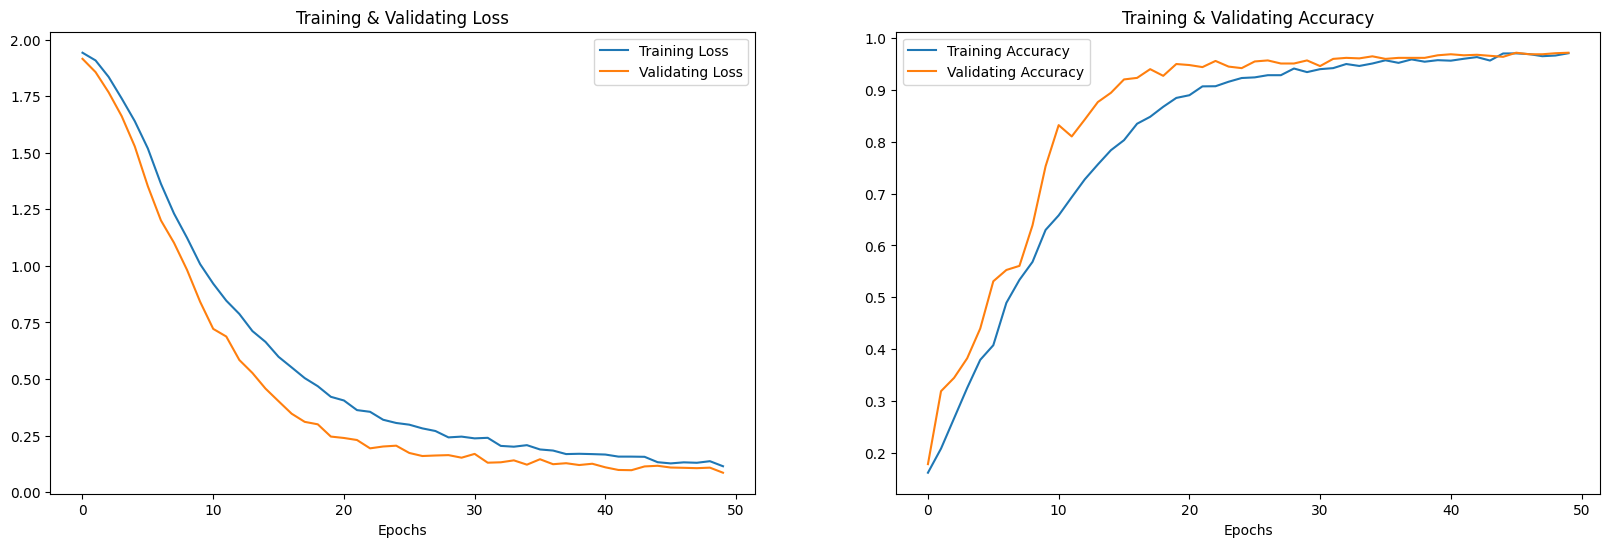

In [18]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: ", test_acc*100 , "%")


epochs = [i for i in range(EPOCHS)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.set_size_inches(20, 6)
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, val_loss, label='Validating Loss')
ax[0].set_title('Training & Validating Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, val_acc, label='Validating Accuracy')
ax[1].set_title('Training & Validating Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [19]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
label_names = list(labels.keys())
print(classification_report(y_test, y_pred, target_names=label_names))

              precision    recall  f1-score   support

     neutral       0.99      0.95      0.97        91
       happy       0.95      0.99      0.97        79
     disgust       0.99      0.95      0.97        78
       angry       0.96      0.96      0.96        84
         sad       0.90      1.00      0.95        65
        fear       0.95      0.95      0.95        79
    surprise       0.98      0.94      0.96        84

    accuracy                           0.96       560
   macro avg       0.96      0.96      0.96       560
weighted avg       0.96      0.96      0.96       560



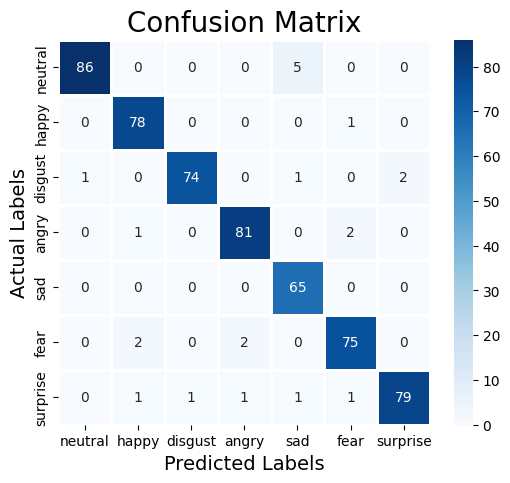

In [20]:
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm)

plt.figure(figsize = (6, 5))
sns.heatmap(cm, xticklabels=label_names, yticklabels=label_names, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [21]:
model.save('./saved_model')
print('Save the Tensorflow model!')
model.save('./saved_model/model.h5')

2023-12-28 02:54:45.774734: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


Save the Tensorflow model!


## Train the generator using knowledge distillation

In [23]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import numpy as np

# Load the teacher model
teacher_model = load_model('./saved_model/model.h5')

# Define and compile the generator model
def build_generator_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(64))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(7, activation='softmax'))
    return model

# Create the generator model
input_shape_generator = (47, 13)
generator_model = build_generator_model(input_shape_generator)

# Compile the generator model
generator_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Assuming you have training data (X_train, y_train)
# Train the generator model using knowledge distillation
def train_generator_with_distillation(generator_model, teacher_model, X_train, y_train, epochs=10, batch_size=128):
    for epoch in range(epochs):
        # Generate pseudo-labels using the teacher model
        teacher_preds = teacher_model.predict(X_train)
        teacher_preds = np.argmax(teacher_preds, axis=1)
        
        # Train the generator using knowledge distillation
        history = generator_model.fit(X_train, teacher_preds, batch_size=batch_size, epochs=1, verbose=1)
        
        # Optionally, you can evaluate the generator on a validation set or print some metrics
        validation_loss = generator_model.evaluate(X_validation, y_validation, verbose=0)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {history.history["loss"][0]}, Validation Loss: {validation_loss[0]}')

# Assuming you have training data (X_train, y_train)
# Convert labels to one-hot encoded format
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=7)

# Train the generator model using knowledge distillation
train_generator_with_distillation(generator_model, teacher_model, X_train, y_train_onehot, epochs=70, batch_size=128)

# Save the trained generator model
generator_model.save('./trained_generator/trained_generator.h5')


32/32 [==============================] - 1s 8ms/step - loss: 1.6807 - accuracy: 0.3353
Epoch 1/70, Loss: 1.6806843280792236, Validation Loss: 1.2038463354110718
32/32 [==============================] - 0s 7ms/step - loss: 0.9109 - accuracy: 0.6711
Epoch 2/70, Loss: 0.9108614325523376, Validation Loss: 0.6070526242256165
32/32 [==============================] - 0s 8ms/step - loss: 0.5313 - accuracy: 0.8217
Epoch 3/70, Loss: 0.5313416123390198, Validation Loss: 0.3831717073917389
32/32 [==============================] - 0s 9ms/step - loss: 0.3467 - accuracy: 0.8976
Epoch 4/70, Loss: 0.3466993272304535, Validation Loss: 0.24515534937381744
32/32 [==============================] - 0s 9ms/step - loss: 0.2719 - accuracy: 0.9201
Epoch 5/70, Loss: 0.2719477415084839, Validation Loss: 0.2746967375278473
32/32 [==============================] - 0s 10ms/step - loss: 0.2624 - accuracy: 0.9231
Epoch 6/70, Loss: 0.2623787522315979, Validation Loss: 0.23051849007606506
32/32 [========================

In [24]:
# Save the trained generator model
generator_model.save('./trained_generator')

INFO:tensorflow:Assets written to: ./trained_generator/assets


INFO:tensorflow:Assets written to: ./trained_generator/assets


In [25]:
test_loss, test_acc = generator_model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: ", test_acc*100 , "%")

Test Accuracy:  98.39285612106323 %


## Prune the model


In [28]:
import tensorflow_model_optimization as tfmot
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Load the saved model
model = load_model('./trained_generator')

# Define the pruning parameters
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=1000)
}

# Apply pruning to the model
model_pruned = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

# Compile the pruned model
model_pruned.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

# Add the UpdatePruningStep callback
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
]

# Fine-tune the pruned model
model_pruned.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                 batch_size=128, epochs=40, callbacks=callbacks)



Epoch 1/40
32/32 [==============================] - 2s 21ms/step - loss: 0.0723 - accuracy: 0.9812 - val_loss: 0.0737 - val_accuracy: 0.9821
Epoch 2/40
32/32 [==============================] - 1s 17ms/step - loss: 0.0377 - accuracy: 0.9893 - val_loss: 0.0798 - val_accuracy: 0.9802
Epoch 3/40
32/32 [==============================] - 1s 17ms/step - loss: 0.0328 - accuracy: 0.9896 - val_loss: 0.0766 - val_accuracy: 0.9772
Epoch 4/40
32/32 [==============================] - 0s 14ms/step - loss: 1.1755 - accuracy: 0.5836 - val_loss: 0.6692 - val_accuracy: 0.7540
Epoch 5/40
32/32 [==============================] - 1s 16ms/step - loss: 0.4365 - accuracy: 0.8539 - val_loss: 0.2779 - val_accuracy: 0.9087
Epoch 6/40
32/32 [==============================] - 1s 16ms/step - loss: 0.1921 - accuracy: 0.9417 - val_loss: 0.2070 - val_accuracy: 0.9375
Epoch 7/40
32/32 [==============================] - 1s 16ms/step - loss: 0.6630 - accuracy: 0.7790 - val_loss: 0.3206 - val_accuracy: 0.9048
Epoch 8/40
32

In [29]:
test_loss, test_acc = model_pruned.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: ", test_acc*100 , "%")

Test Accuracy:  98.21428656578064 %


In [ ]:
# Strip the pruning wrappers from the pruned model
model_stripped = tfmot.sparsity.keras.strip_pruning(model_pruned)

# save the pruned model
model_pruned.save('./pruned_model')
model_pruned.save('./pruned_model/model.h5')

In [31]:
print("Model Sizes:")
!ls -lh saved_model | awk '{print $5 "\t" $9}'

Model Sizes:
	
4.0K	assets
22K	keras_metadata.pb
1.7M	model.h5
2.1M	saved_model.pb
4.0K	variables


In [32]:
print("Model Sizes:")
!ls -lh pruned_model | awk '{print $5 "\t" $9}'

Model Sizes:
	
4.0K	assets
27K	keras_metadata.pb
375K	model.h5
2.0M	saved_model.pb
4.0K	variables


In [34]:
print("Model Sizes:")
!ls -lh trained_generator | awk '{print $5 "\t" $9}'

Model Sizes:
	
4.0K	assets
16K	keras_metadata.pb
1.4M	saved_model.pb
1.6M	trained_generator.h5
4.0K	variables


In [39]:
converter = tf.lite.TFLiteConverter.from_saved_model("./trained_generator")
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

2023-12-28 03:05:36.717314: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-12-28 03:05:36.717341: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-12-28 03:05:36.717424: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: ./trained_generator
2023-12-28 03:05:36.724387: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-12-28 03:05:36.724402: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: ./trained_generator
2023-12-28 03:05:36.752026: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-12-28 03:05:36.824582: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: ./trained_generator
2023-12-28 03:05:36.879624: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Too

In [40]:
converter = tf.lite.TFLiteConverter.from_saved_model("./trained_generator")
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

2023-12-28 03:05:39.994133: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-12-28 03:05:39.994162: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-12-28 03:05:39.994246: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: ./trained_generator
2023-12-28 03:05:40.001583: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-12-28 03:05:40.001598: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: ./trained_generator
2023-12-28 03:05:40.033028: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-12-28 03:05:40.104907: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: ./trained_generator
2023-12-28 03:05:40.159793: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Too

In [41]:
len(tflite_model), len(tflite_quant_model)

(526344, 151664)

In [42]:
with open("./trained_generator/tflite_model.tflite", "wb") as f:
    f.write(tflite_model)

with open("./trained_generator/tflite_quant_model.tflite", "wb") as f:
    f.write(tflite_quant_model)

In [43]:
print("Model Sizes:")
!ls -lh trained_generator | awk '{print $5 "\t" $9}'

Model Sizes:
	
4.0K	assets
16K	keras_metadata.pb
1.4M	saved_model.pb
515K	tflite_model.tflite
149K	tflite_quant_model.tflite
1.6M	trained_generator.h5
4.0K	variables


In [45]:
def evaluate_tflite(interpreter, test_data, test_label):
    # Get the input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    num_correct = 0
    num_total = 0

    # Iterate over the testing data.
    for i in range(test_data.shape[0]):
        # Get the input data for this example.
        input_data = np.array([test_data[i]], dtype=np.float32)

        # Set the input tensor.
        interpreter.set_tensor(input_details[0]['index'], input_data)

        # Run inference.
        interpreter.invoke()

        # Get the output tensor.
        output_data = interpreter.get_tensor(output_details[0]['index'])

        # Compute the predicted label.
        predicted_label = np.argmax(output_data)

        # Update the results.
        if predicted_label == test_label[i]:
            num_correct += 1
        num_total += 1

    # Reset all variables so it will not pollute other inferences.
    interpreter.reset_all_variables()
    
    # Compute the accuracy.
    accuracy = num_correct / num_total
    
    return accuracy

In [44]:
# Load tflite model.
interpreter = tf.lite.Interpreter(model_path="trained_generator/tflite_quant_model.tflite")
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite delegate for select TF ops.
2023-12-28 03:08:19.880256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-28 03:08:19.880661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-28 03:08:19.880888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-28 03:08:19.881212: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-28 03:08:19.881426: I tensorflow/stream_executor/cuda/

In [ ]:
tflite_test_acc = evaluate_tflite(interpreter, X_test, y_test)
print(f"TF Lite Model Accuracy: {tflite_test_acc * 100:.2f}%")
print(f"Accuracy Difference from Original Model: {(test_acc-tflite_test_acc) * 100:.2f}%")